## Surface Determination Workflow  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from tomo_encoders import Patches, DataFile
import tensorflow as tf
import time, glob

sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/scratchpad/surface_determination/trainer')
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
from tomo_encoders.misc.feature_maps_vis import view_midplanes
from tomo_encoders.misc.voxel_processing import normalize_volume_gpu
from tomo_encoders.misc.viewer import view_midplanes

In [2]:
######## START GPU SETTINGS ############
########## SET MEMORY GROWTH to True ############
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass        
######### END GPU SETTINGS ############

In [3]:
from params import *
# model_tags = ["M_a02", "M_a04", "M_a05", "M_a01", "M_a03", "M_a06"]
TRAINING_INPUT_SIZE = (64,64,64)

In [3]:
############## PATHS ##################
# Sample 1
# sz = slice(750, 1350, None)
# sy = sx = slice(400, 1800, None)    
# fpath = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample1/FDK1X/'

# Sample 2
sz = slice(800, 1500, None)
sy = sx = slice(200, 1900, None)    
fpath = '/data02/MyArchive/tomo_datasets/ZEISS_try2/Sample2/FDK1X'

In [5]:
model_tag = "M_a04"
print("#"*55, "\nWorking on model %s\n"%model_tag, "#"*55)
model_names = {"segmenter" : "segmenter_Unet_%s"%model_tag}

model_params = get_model_params(model_tag)
fe = SurfaceSegmenter(model_initialization = 'load-model', \
                      model_names = model_names, \
                      model_path = model_path)

####################################################### 
Working on model M_a04
 #######################################################

 ####################################################### 


Model is M_a04
n_filters [32, 64]
n_blocks 2
activation lrelu
batch_norm True
isconcat [True, True]
pool_size [2, 4]


In [10]:
ds = DataFile(fpath, tiff = True)
vol = ds.read_full().astype(np.float32)
img = vol[-1].copy()
vol[vol == 0] = np.mean(img[500:1500,500:1500])
vol = vol[sz, sy, sx]
vol = normalize_volume_gpu(vol, normalize_sampling_factor = 4, chunk_size = 1).astype(np.float32)


##################################################
Found existing tiff folder: FDK1X
Dataset shape: (2026, 2026, 2026)


In [7]:
# Segmentation step
t00 = time.time()
p_grid = Patches(vol.shape, initialize_by = 'grid', patch_size = TRAINING_INPUT_SIZE)
x = p_grid.extract(vol, TRAINING_INPUT_SIZE)
y_pred = fe.predict_patches("segmenter", x[...,np.newaxis], 32, None)[...,0]
vol_seg = np.zeros_like(vol)
p_grid.fill_patches_in_volume(y_pred, vol_seg)
t01 = time.time()

In [8]:
print(f'total segmentation time: {t01-t00:.2f} seconds')

total segmentation time: 364.16 seconds


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

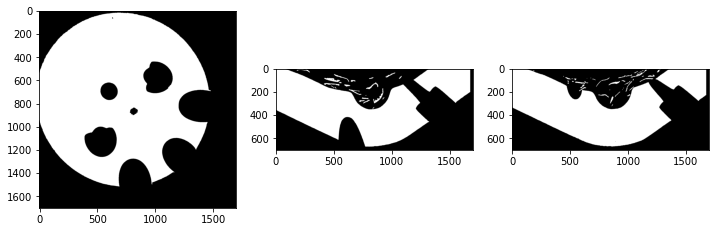

In [9]:
fig, ax = plt.subplots(1,3, figsize = (12,6))
view_midplanes(vol_seg, ax = ax)

In [10]:
vol_seg.shape

(700, 1700, 1700)

In [26]:
np.unique(vol_seg)

array([0., 1.], dtype=float32)